# Read data from CSV files


## Import libraries

In [1]:
import pandas as pd
import numpy as np

## Read data function

In [2]:
def read_csv_to_dataframe(filename):
    df = pd.read_csv(filename)
    return df

## Test function

In [14]:
filename = './data/ONGC.NS.csv'
df = read_csv_to_dataframe(filename)

<Axes: >

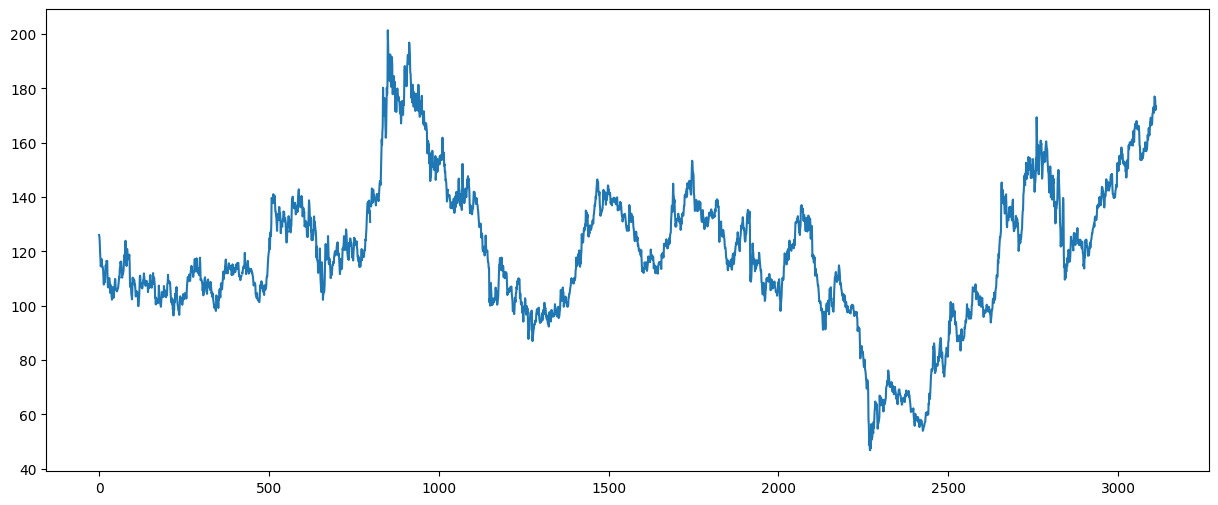

In [15]:
df['Adj Close'].plot(figsize=(15, 6))

# Calculate historical returns

We calculate Historical returns based on Adj Close (Adjusted Close Price).

We denote Historical returns as $R$, Adj Close as $AC$.

The original formula is: $R_t = \frac{AC_{t} - AC_{t-1}}{AC_{t-1}} * 100$.

Let calculate and make a plot with the data of **ONGC (Oil And Natural Gas Corporation)** Company as an example.

/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/2143120690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Adj Close'].pct_change()


<Axes: >

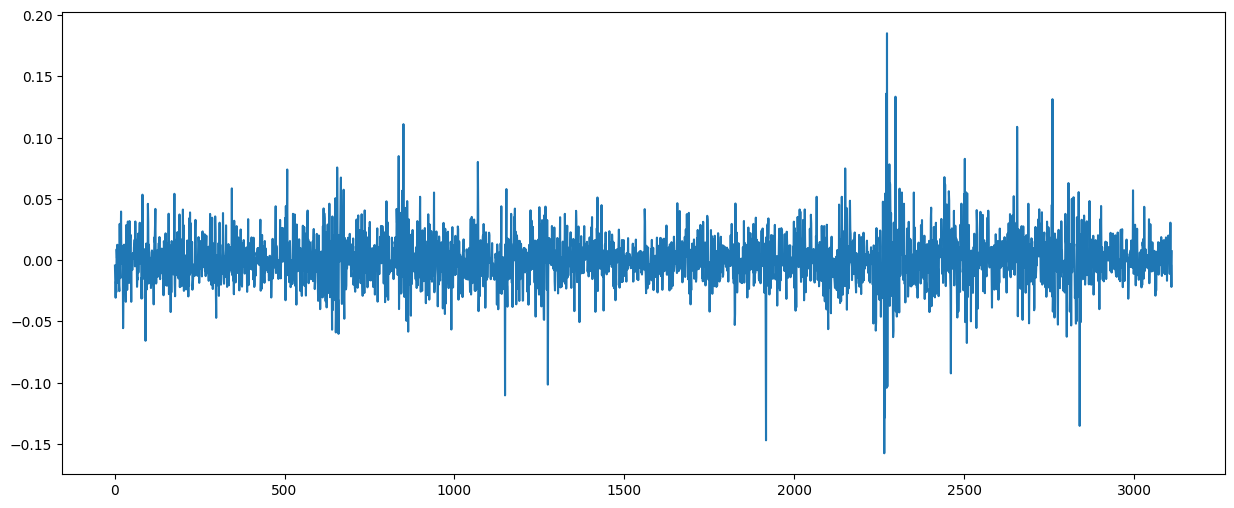

In [16]:
return_df = df[['Date', 'Adj Close']]
return_df['Historical Return'] = return_df['Adj Close'].pct_change()
return_df = return_df.dropna()
return_df['Historical Return'].plot(figsize=(15,6))

<Axes: >

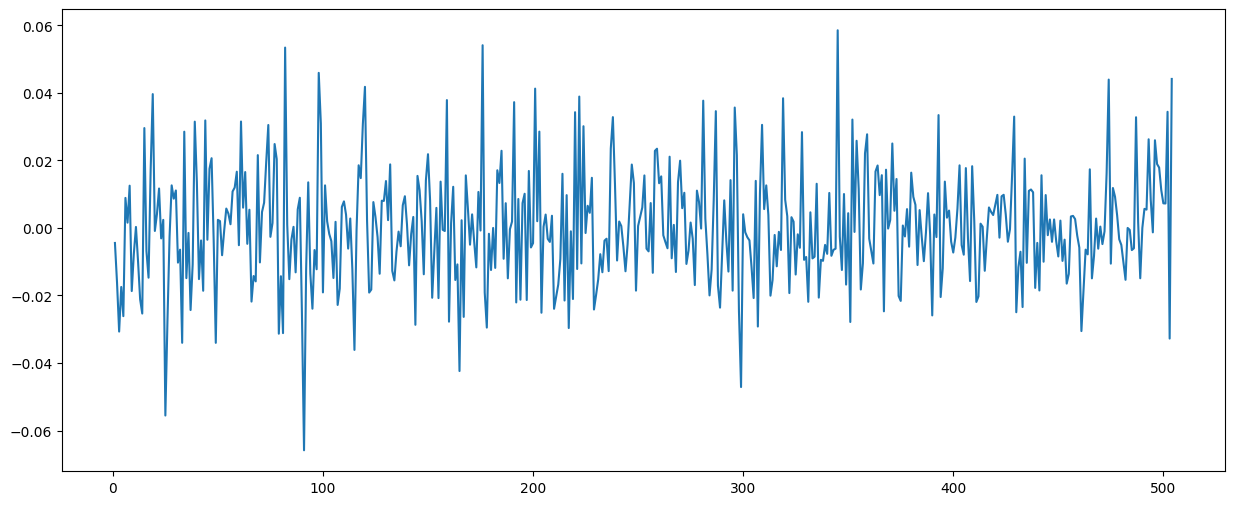

In [17]:
# Plot with 0-500 data 
return_df['Historical Return'].iloc[0:500].plot(figsize=(15,6))

These plots show that the original formula is very sensitive to price fluctuations, and maybe not suitable for forecasting. 

We decide looking for a return calculation method that is less sensitve.

Then, we found **EMA (Exponential Moving Average) returns**. The EMA is a type of moving average that gives more weight to recent data points, which can help smooth out the fluctuations and provide a more stable return series.

When applying EMA, we calculate Historical Return following 3 steps:

* Calculate the daily returns using the formula: $Daily Return_t = \frac{AC_{t} - AC_{t-1}}{AC_{t-1}}$

* Calculate the smoothing factor (alpha) for the EMA: $\alpha = \frac{2}{period + 1}$

* Calculate the Historical return for each day using the formula: $R_t = R_{t-1} + \alpha*(Daily Return_t - R_{t-1})$

Let's continuing our experiments about  **ONGC** with EMA-30days (Period of 1 month)

/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/22253793.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/22253793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()


<Axes: >

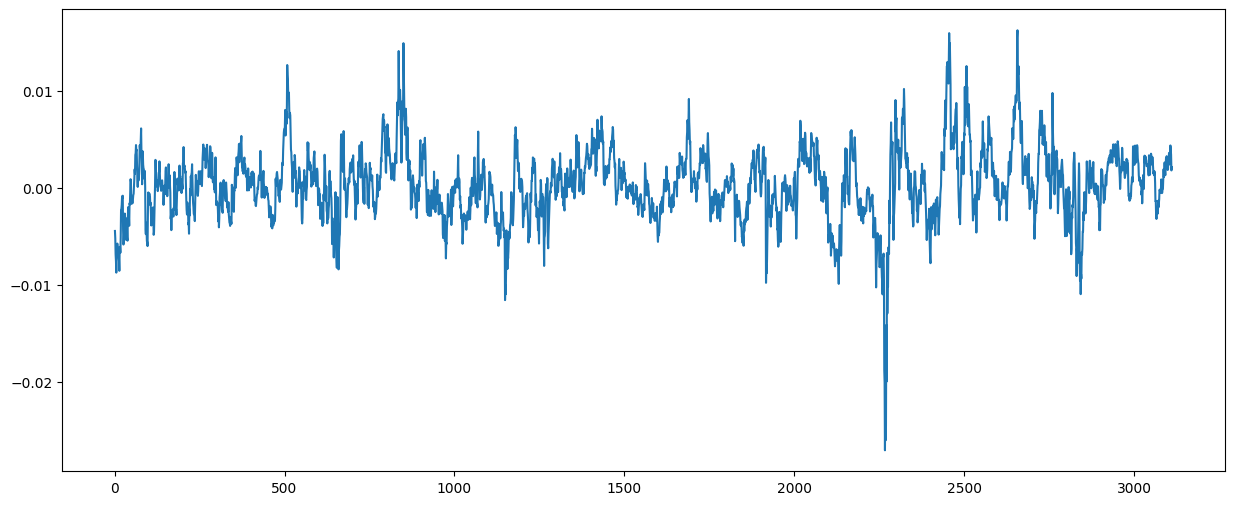

In [37]:
return_df = df[['Date', 'Adj Close']]

# Calculate Daily returns
return_df['Daily Return'] = return_df['Adj Close'].pct_change()

# Set the smoothing factor (alpha) for EMA
alpha = 2/(30 + 1)

# Calculate Historical returns
return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
return_df['Historical Return'].plot(figsize=(15,6))

<Axes: >

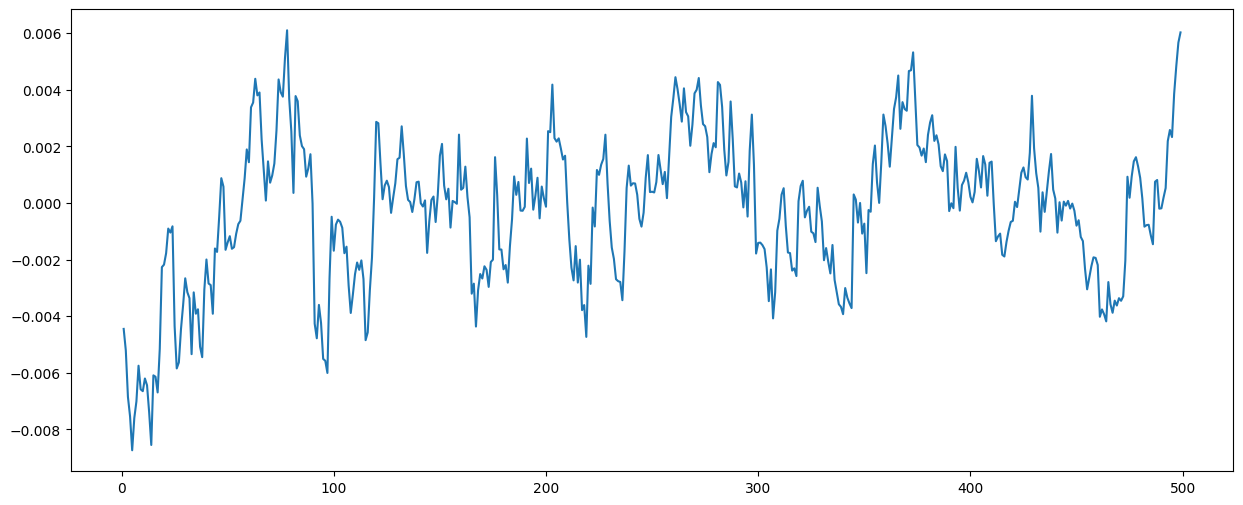

In [39]:
return_df['Historical Return'].iloc[0:500].plot(figsize=(15,6))

It looks better, let's move to the next step - model.

Before that, we define a function which can get csv data, calculate Historical return and split them following the 80-20 ratio for trainning model.

In [40]:
# Import libraries
from sklearn.model_selection import train_test_split as tts

# Function
def get_data(filename, period):
    df = read_csv_to_dataframe(filename)
    return_df = df[['Date', 'Adj Close']]

    # Calculate Daily returns
    return_df['Daily Return'] = return_df['Adj Close'].pct_change()

    # Set the smoothing factor (alpha) for EMA
    alpha = 2/(period + 1)

    # Calculate EMA returns
    return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()

    # Save current return for predicting
    current_return = return_df['Historical Return'].iloc[-1]

    # Create Predict column
    return_df['Predict'] = return_df['Historical Return'].shift(1)
    return_df = return_df.dropna()

    # Split dataset
    train_df, test_df = tts(return_df[['Historical Return', 'Predict']], train_size = 0.8, shuffle = False)
    x_train = train_df.drop(columns = ['Predict'])
    y_train = train_df['Predict']
    x_test= test_df.drop(columns = ['Predict'])
    y_test = test_df['Predict']
    return x_train, y_train, x_test, y_test, current_return, alpha

# Model

* **Goal:** Based on the Historical return of a certain stock, feed the data into a prediction model and use that data to make predictions about the future returs of that stock.

* **Method:** Bagging Ensemble Learning. (Train more than one models. Each model will be trained independently. The results based on all model results.)

* **Models:** 
    * Linear Regression 

    * Gradient Boosting Tree 
    
    * k-Nearest Neighbors

* **Evaluate:** RMSE (Root Mean Squared Error)

In [150]:
# Import libraries
import numpy as np
import pandas as pd
from xgboost import XGBRegressor as regressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from statistics import mean

In [162]:
# k-Nearest Neighbors model
def knn_df(filename, period):
     # Get data
     x_train, y_train, x_test, y_test, current_return, alpha = get_data(filename, period)
     
     # Model training and evaluating
     model = KNeighborsRegressor(n_neighbors=5)
     model.fit(x_train, y_train)
     print(model.score(x_test, y_test))
     
     # Model predicting
     predict = model.predict(x_test)
     predict_df = pd.DataFrame({'predict': predict,'real':y_test}, index = None)

     # Future predicting
     cur_return = current_return
     predict_return_list = []
     for i in range(30):
          tmp_return = cur_return
          predict_return = model.predict([[tmp_return]])
          predict_return_list.append(predict_return[0])
          cur_return=predict_return[0]
     
     predict_df = pd.DataFrame({'Predicted Returns': np.concatenate((predict, predict_return_list), axis=0)}, index = None)
     y_test = y_test.reset_index()
     y_test = y_test.drop(columns='index')
     real_df = pd.DataFrame({'Real Returns': y_test['Predict']}, index = None)
     average_predict = mean(predict_return_list)
     return predict_df, real_df, average_predict

In [156]:
# Linear Regression model
def linear_df(filename, period):
    # Get data
    x_train, y_train, x_test, y_test, current_return, alpha = get_data(filename, period)

    # Model trainning and evaluating
    model = LinearRegression()
    model.fit(x_train, y_train)
    print(model.score(x_test, y_test))

    # Model predicting
    predict = model.predict(x_test)

    # Future predicting
    cur_return = current_return
    predict_return_list = []
    for i in range(30):
        tmp_return = cur_return
        predict_return = model.predict([[tmp_return]])
        predict_return_list.append(predict_return[0])
        cur_return=predict_return[0]
     
    predict_df = pd.DataFrame({'Predicted Returns': np.concatenate((predict, predict_return_list), axis=0)}, index = None)
    y_test = y_test.reset_index()
    y_test = y_test.drop(columns='index')
    real_df = pd.DataFrame({'Real Returns': y_test['Predict']}, index = None)
    average_predict = mean(predict_return_list)
    return predict_df, real_df, average_predict    

In [159]:
## Gradient Boosting Tree model
def xgb_df(filename, period):
    # Get data
    x_train, y_train, x_test, y_test, current_return, alpha = get_data(filename, period)

    # Model training and evaluating
    x_train, x_val, y_train, y_val = tts(x_train, y_train, train_size = 0.8, shuffle = False) 
    model = regressor(learning_rate = 0.06, max_depth = 6, n_estimators = 100)
    model.fit(x_train,y_train, eval_set = [(x_val, y_val)], eval_metric = 'rmse', verbose = False)
    print(model.score(x_test, y_test))

    # Model predicting
    predict = model.predict(x_test)
    predict_df = pd.DataFrame({'predict': predict,'real':y_test},index = y_test.index)

    # Future predicting
    df = pd.DataFrame({'Historical Return': [current_return]})
    predict_return_list = []
    for i in range(30):
        tmp_df = df
        predict_return = model.predict(tmp_df)
        predict_return_list.append(predict_return[0])
        df = pd.DataFrame({'Historical Return': [predict_return[0]]})
    
    predict_df = pd.DataFrame({'Predicted Returns': np.concatenate((predict, predict_return_list), axis=0)}, index = None)
    y_test = y_test.reset_index()
    y_test = y_test.drop(columns='index')
    real_df = pd.DataFrame({'Real Returns': y_test['Predict']}, index = None)
    average_predict = mean(predict_return_list)
    return predict_df, real_df, average_predict

In [145]:
def plot_result(predict_df, real_df):
    ax = predict_df.plot(figsize=(15,6))
    real_df.plot(ax=ax)

## Reliance Industries Limited (RIL)

0.8077868971004318


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:22: SettingWit

-0.2793990977258486

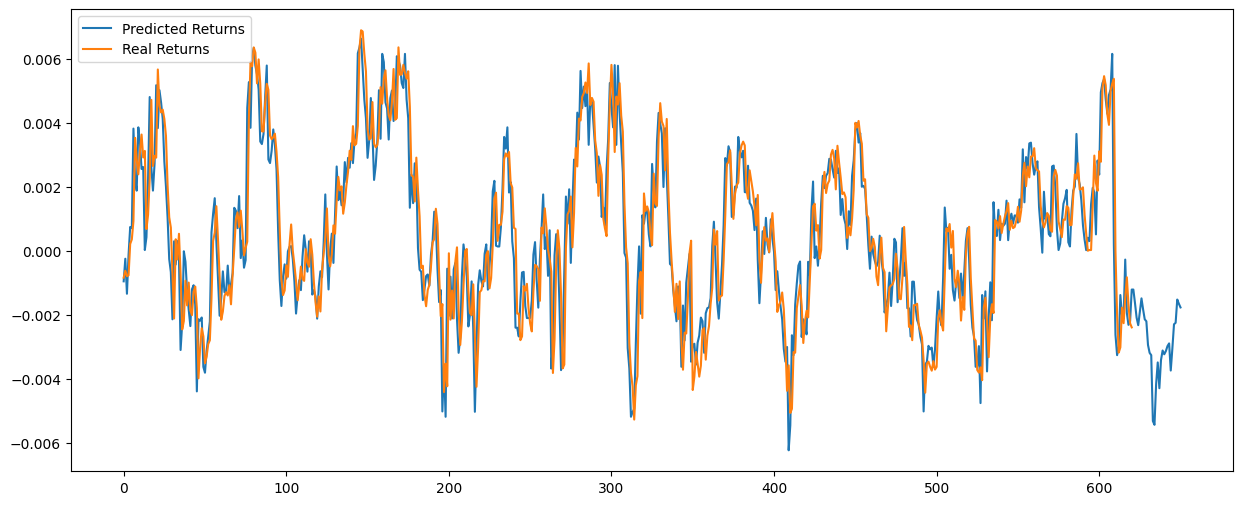

In [161]:
predict_df, real_df, average_predict = knn_df('./data/RELIANCE.NS.csv', 30)
plot_result(predict_df, real_df)
average_predict*100

0.84071163567674


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:22: SettingWit

-0.00468423964915497

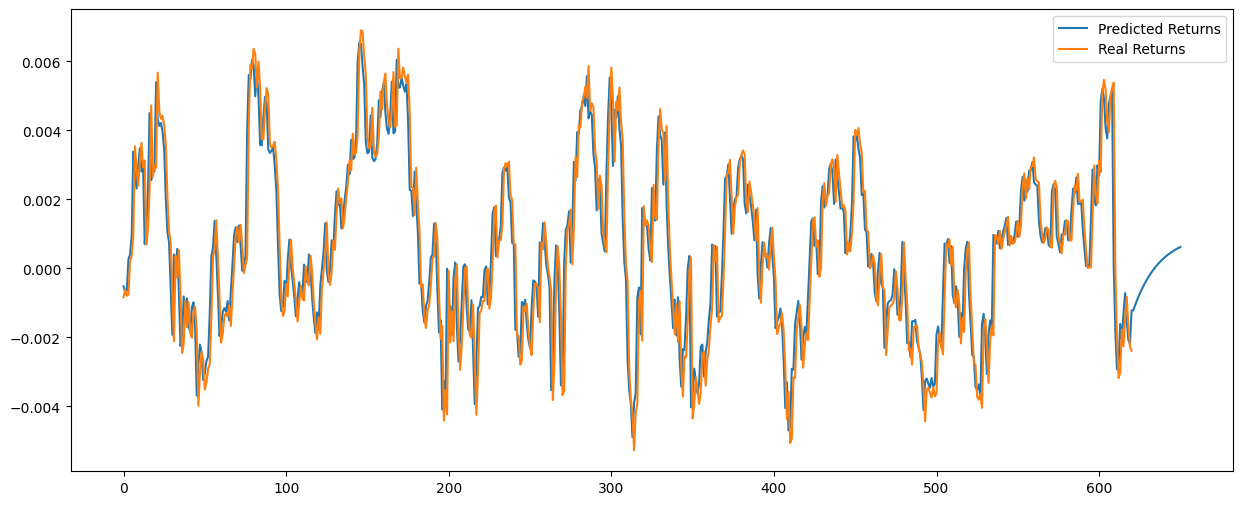

In [157]:
predict_df, real_df, average_predict = linear_df('./data/RELIANCE.NS.csv', 30)
plot_result(predict_df, real_df)
average_predict*100

0.6771342567222034


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_28880/3941445349.py:22: SettingWit

0.641753850504756

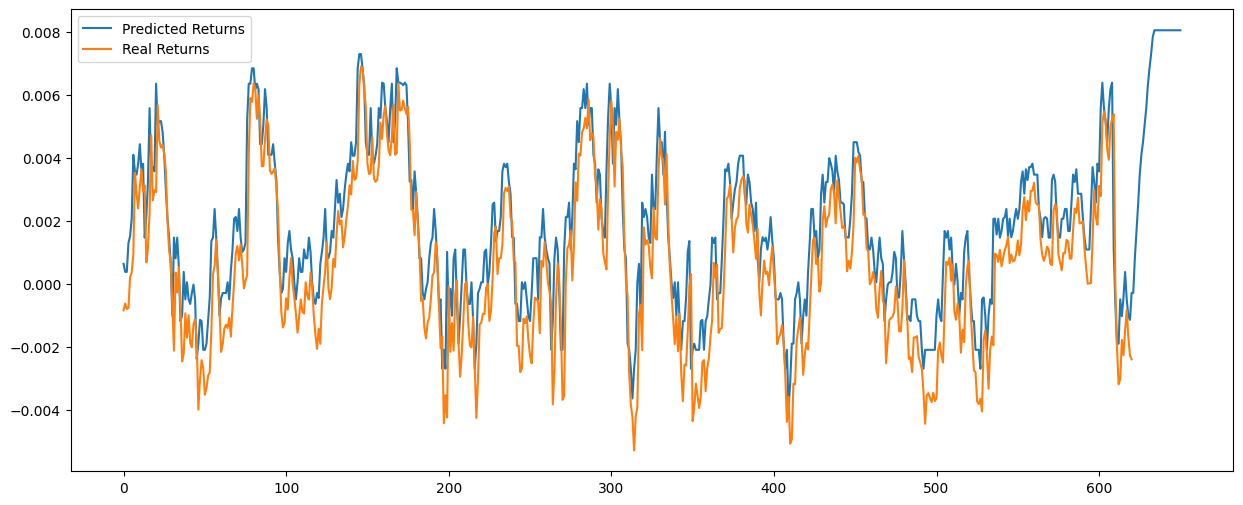

In [160]:
predict_df, real_df, average_predict = xgb_df('./data/RELIANCE.NS.csv', 30)
plot_result(predict_df, real_df)
average_predict*100

## Oil and Natural Gas Corporation Limited (ONGC)

## Petronet LNG Limited (PETRONET)

## Oil India Limited (OIL)

## Hindustan Oil Exploration Company Limited (HINDOILEXP)